In [165]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [166]:
import numpy as np
import pandas as pd

In [167]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [168]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [169]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [170]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [171]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [172]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [173]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [174]:
# Gete databas tables

inspector = inspect(engine)

inspector.get_table_names()


['measurement', 'station']

In [175]:
# Get a list of column names and types

columns = inspector.get_columns('measurement')

for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


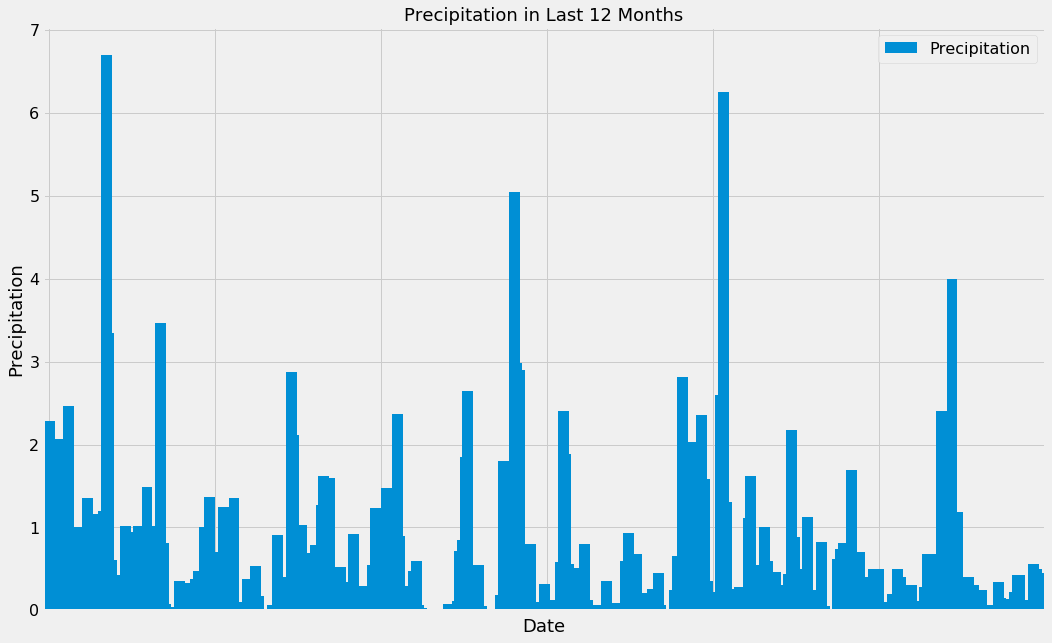

In [176]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
# Getting Latest Date
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date

# Getting 12 months back date from latest date
twelve_months_old_date = dt.datetime.strptime(latest_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, func.max(Measurement.prcp)).filter(Measurement.date >= last_twelve_months).\
group_by(Measurement.date).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(p_results, columns=['Date', 'Precipitation'])
precipitation_df.set_index('Date', inplace=True)
#precipitation_df.head()

# Sort the dataframe by date
precipitation_df.sort_values(by=['Date'])

# Use Pandas Plotting with Matplotlib to plot the data
ax = precipitation_df.plot(kind='bar', width=4, figsize=(16,10))
plt.locator_params(axis='x', nbins=6)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.tick_params(axis='y', labelsize=16)
ax.grid(True)
plt.legend(bbox_to_anchor=(1,1), fontsize="16")
plt.title("Precipitation in Last 12 Months", size=18)
plt.ylabel("Precipitation", size=18)
plt.xlabel("Date", size=18)
plt.savefig("Output/Precipitation.png")

plt.show()

In [178]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,365.000000
mean,0.517288
std,0.829196
min,0.000000
25%,0.040000
50%,0.250000
75%,0.650000
max,6.700000


In [179]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.id).count()

9

In [180]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [181]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = most_active_stations[0][0]
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                filter(Measurement.station == most_active_station).all()

[(54.0, 85.0, 71.66378066378067)]

In [182]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station 
temp_observations = session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == most_active_station).\
                filter(Measurement.date >= twelve_months_old_date).all()
tobs_df = pd.DataFrame(temp_observations)
tobs_df.set_index('station', inplace=True)
tobs_df.head()

,tobs
station,
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0
USC00519281,73.0


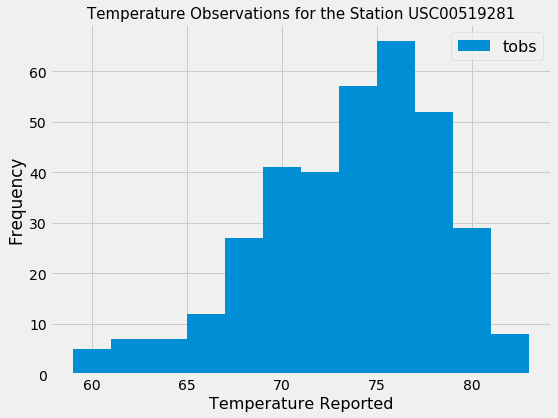

In [183]:
# plot the above results as a histogram
tobs_df.plot.hist(by='station', bins=12, figsize=(8,6))
plt.title("Temperature Observations for the Station " + most_active_station, fontsize=15)
plt.xlabel("Temperature Reported", fontsize=16)
plt.legend(bbox_to_anchor=(1,1), fontsize=16)
plt.savefig("Output/MostActiveStationTemps.png")
plt.show()


In [184]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [185]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps(twelve_months_old_date, latest_date))

[(58.0, 74.57894736842105, 87.0)]


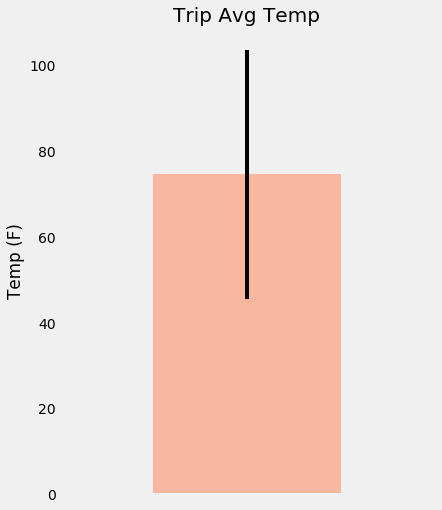

In [186]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_results = calc_temps(twelve_months_old_date, latest_date)
trip_df = pd.DataFrame(trip_results, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trip_df['Avg Temp']
min_max_temp = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='coral')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid()
plt.savefig("Output/TripAvgTempSummary.png")
plt.show()

In [187]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
results = session.query(Station.station,
                        Station.name,
                        Station.latitude,
                        Station.longitude,
                       Station.elevation,                        
                      func.avg(Measurement.prcp))\
.filter(Measurement.station == Station.station)\
.filter(Measurement.date >= twelve_months_old_date)\
.filter(Measurement.date <= latest_date)\
.group_by(Station.station)\
.order_by(func.sum(Measurement.prcp).desc())

for result in results: print(result)


('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.4498776758409787)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.1944159544159545)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.1414035087719299)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.12137380191693291)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.12571969696969695)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.04494413407821225)
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0765)


## Optional Challenge Assignment

In [188]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [189]:
# calculate the daily normals for your trip
#create a list of dates for your trip 
trip_dates = pd.date_range(twelve_months_old_date, latest_date)

#Changing Date format it to %m-%d
trip_dates_mmdd = trip_dates.strftime('%m-%d')

#calculate the normals for each date string and append the results to a list
normals_list = []
for trip_date in trip_dates_mmdd:
    #unpack daily_normals
    normals_list.append(*daily_normals(trip_date))
    
normals_list[0:10]  


[(67.0, 76.6923076923077, 87.0),
 (70.0, 75.96153846153847, 84.0),
 (69.0, 76.96078431372548, 82.0),
 (71.0, 76.56862745098039, 84.0),
 (68.0, 76.28301886792453, 84.0),
 (67.0, 76.73469387755102, 86.0),
 (70.0, 76.23529411764706, 85.0),
 (68.0, 76.41666666666667, 84.0),
 (67.0, 76.84, 85.0),
 (69.0, 77.0, 82.0)]

In [190]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals_list, columns = ['Tmin', 'Tavg', 'Tmax'])

normals_df['Date'] = trip_dates
normals_df = normals_df.set_index('Date')

normals_df.head()

,Tmin,Tavg,Tmax
Date,,,
2016-08-23,67.0,76.692308,87.0
2016-08-24,70.0,75.961538,84.0
2016-08-25,69.0,76.960784,82.0
2016-08-26,71.0,76.568627,84.0
2016-08-27,68.0,76.283019,84.0


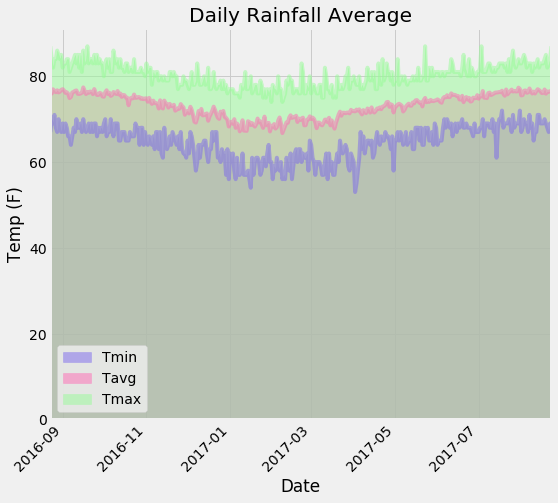

In [191]:
# Plot the daily normals as an area plot with `stacked=False`
colors = ['mediumslateblue', 'hotpink', 'palegreen']

#make an area plot for the predicted temps
normals_df.plot(kind='area', figsize=(8, 8), stacked=False, x_compat=True, color=colors, title='Daily Rainfall Average', rot=45)

#make the labels
plt.xlabel('Date')
plt.ylabel('Temp (F)')
plt.savefig("Output/DailyRainfallAverage.png")
plt.show()